# Homework 1. Part 3.3

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from torch.utils.data import DataLoader

In [2]:
# Setting default device

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

display(f'{device} is available')

dtype = torch.float
torch.set_default_device(device)

'cuda is available'

### Modifiable model

In [3]:
class ChangeableNetwork(nn.Module):
    def __init__(self, modification=512):
        super().__init__()
        self.linear_relu = nn.Sequential(
            nn.Linear(28*28, modification),
            nn.ReLU(),
            nn.Linear(modification,modification),
            nn.ReLU(),
            nn.Linear(modification, 10),
        )

    def forward(self, x):
        flat = nn.Flatten()
        x = flat(x)
        logits = self.linear_relu(x)
        return logits

### Utility Functions

In [4]:
def cnt_model_params(model):
    """Count model parameters"""
    count = 0
    with torch.no_grad():
        for param in model.parameters():
            count+=param.numel()
    return count

def display_model_info(model_name, model):
    """ Display model information"""
    count = 0
    for module in model.modules():
        if isinstance(module, nn.Module):
            count+=1
    display(model)
    display(f"{model_name}. parameters: {cnt_model_params(model)}")

In [5]:
# Randomly changed the lavels on the training dataset. Kept labels the same on test dataset.
training_ds = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
test_ds = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())


### Training & eval loops

In [6]:
def nmist_train_loop(dataloader, model, loss_fn, optimize):
    model.train()
    num_batches = len(dataloader)
    train_loss, correct = 0,0
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        optimize.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()

        loss.backward()
        optimize.step()
    
    train_loss /= num_batches
    correct /=size
    return train_loss, correct
        
def nmist_val_loop(dataloader, model, loss_fn):
    model.eval()
    size= len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0,0

    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(dim=1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /=size
    return test_loss, correct

## Flatness v.s. Generalization part1

In [7]:
# create models and with different Hidden values
m1, m2 = ChangeableNetwork(512), ChangeableNetwork(512)
display_model_info(1, m1)
display_model_info(2, m2)

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'1. parameters: 669706'

ChangeableNetwork(
  (linear_relu): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

'2. parameters: 669706'

In [8]:
# hyperparameters
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20
lr = 1e-3

models = (m1,m2)

batch_sizes = (64, 2048)

fit_df = pd.DataFrame()

for batch_size, model in zip(batch_sizes, models):
    optimizer1 = torch.optim.SGD(model.parameters(), lr=lr)
    display(f"Training & eval: Models with batch size: {batch_size}")

    # Dataloader
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
   
    for epoch in range(epochs):
        train_loss, t_correct = nmist_train_loop(training_dl, model, loss_fn, optimizer1)
        val_loss, v_correct = nmist_val_loop(test_dl, model, loss_fn)
        display(f'Epoch {epoch}. Training_loss: {train_loss}. Val_loss: {val_loss}. Training_accuracy: {t_correct}. Val_accuracy: {v_correct}')
    display("Done")
    
    #if fit_df.empty:
    #    fit_df = pd.DataFrame([[epoch, train_loss, val_loss, t_correct, v_correct, cnt_model_params(model)]], columns=['epoch','train_loss','val_loss', 'train_acc', 'v_acc','parameters'])
    #else:
    #    columns=['epoch','train_loss','val_loss', 'train_acc', 'v_acc','parameters']
    #    fit_df = pd.concat([fit_df, pd.DataFrame([[epoch, train_loss, val_loss, t_correct, v_correct, cnt_model_params(model)]], columns=columns )])

'Training & eval: Models with batch size: 64'

'Epoch 0. Training_loss: 2.2790911700933982. Val_loss: 2.252909317138089. Training_accuracy: 0.24923333333333333. Val_accuracy: 0.377'

'Epoch 1. Training_loss: 2.221677227569287. Val_loss: 2.1817465739645017. Training_accuracy: 0.4402333333333333. Val_accuracy: 0.5086'

'Epoch 2. Training_loss: 2.130654209204066. Val_loss: 2.062831356267261. Training_accuracy: 0.5467666666666666. Val_accuracy: 0.5931'

'Epoch 3. Training_loss: 1.9783730880538029. Val_loss: 1.8672760671870723. Training_accuracy: 0.6297666666666667. Val_accuracy: 0.6653'

'Epoch 4. Training_loss: 1.7426248609638417. Val_loss: 1.584347860069032. Training_accuracy: 0.6902166666666667. Val_accuracy: 0.7184'

'Epoch 5. Training_loss: 1.4409362099318108. Val_loss: 1.2707231458584973. Training_accuracy: 0.7324666666666667. Val_accuracy: 0.7596'

'Epoch 6. Training_loss: 1.1567084097277636. Val_loss: 1.021027564622794. Training_accuracy: 0.7680833333333333. Val_accuracy: 0.7876'

'Epoch 7. Training_loss: 0.9495860786834506. Val_loss: 0.8518794144794439. Training_accuracy: 0.79465. Val_accuracy: 0.8088'

'Epoch 8. Training_loss: 0.8097716704932357. Val_loss: 0.7372857110135874. Training_accuracy: 0.81315. Val_accuracy: 0.8232'

'Epoch 9. Training_loss: 0.7128398672604104. Val_loss: 0.6560560415504845. Training_accuracy: 0.8273666666666667. Val_accuracy: 0.8382'

'Epoch 10. Training_loss: 0.6425936025088784. Val_loss: 0.5959137171317058. Training_accuracy: 0.8387. Val_accuracy: 0.8474'

'Epoch 11. Training_loss: 0.5896838517712631. Val_loss: 0.5497835574636034. Training_accuracy: 0.8490333333333333. Val_accuracy: 0.8592'

'Epoch 12. Training_loss: 0.5485891457369079. Val_loss: 0.5134386823625322. Training_accuracy: 0.8575166666666667. Val_accuracy: 0.8673'

'Epoch 13. Training_loss: 0.5158851284430479. Val_loss: 0.48418433622569795. Training_accuracy: 0.86505. Val_accuracy: 0.8721'

'Epoch 14. Training_loss: 0.48932771883539555. Val_loss: 0.4602294615499533. Training_accuracy: 0.8704666666666667. Val_accuracy: 0.8771'

'Epoch 15. Training_loss: 0.4673995143378467. Val_loss: 0.4403385310700745. Training_accuracy: 0.8753833333333333. Val_accuracy: 0.882'

'Epoch 16. Training_loss: 0.4490300439663533. Val_loss: 0.4236136015243591. Training_accuracy: 0.8792666666666666. Val_accuracy: 0.8855'

'Epoch 17. Training_loss: 0.4334437117171186. Val_loss: 0.40938930351073577. Training_accuracy: 0.8824833333333333. Val_accuracy: 0.8877'

'Epoch 18. Training_loss: 0.42006390220098405. Val_loss: 0.3971633780154453. Training_accuracy: 0.88505. Val_accuracy: 0.8902'

'Epoch 19. Training_loss: 0.4084549311365781. Val_loss: 0.3865493216142533. Training_accuracy: 0.88795. Val_accuracy: 0.8925'

'Done'

'Training & eval: Models with batch size: 2048'

'Epoch 0. Training_loss: 2.302166549364726. Val_loss: 2.301596260070801. Training_accuracy: 0.12015. Val_accuracy: 0.1284'

'Epoch 1. Training_loss: 2.300552185376485. Val_loss: 2.2999430179595945. Training_accuracy: 0.12828333333333333. Val_accuracy: 0.1368'

'Epoch 2. Training_loss: 2.2989449501037598. Val_loss: 2.298296308517456. Training_accuracy: 0.13555. Val_accuracy: 0.1432'

'Epoch 3. Training_loss: 2.2973435084025065. Val_loss: 2.296655607223511. Training_accuracy: 0.14248333333333332. Val_accuracy: 0.1489'

'Epoch 4. Training_loss: 2.295746922492981. Val_loss: 2.2950190544128417. Training_accuracy: 0.14963333333333334. Val_accuracy: 0.1569'

'Epoch 5. Training_loss: 2.2941543658574424. Val_loss: 2.2933859825134277. Training_accuracy: 0.15578333333333333. Val_accuracy: 0.1627'

'Epoch 6. Training_loss: 2.2925644715627036. Val_loss: 2.2917550086975096. Training_accuracy: 0.16251666666666667. Val_accuracy: 0.1675'

'Epoch 7. Training_loss: 2.2909759124120077. Val_loss: 2.2901257038116456. Training_accuracy: 0.1689. Val_accuracy: 0.1746'

'Epoch 8. Training_loss: 2.2893879493077596. Val_loss: 2.28849720954895. Training_accuracy: 0.17568333333333333. Val_accuracy: 0.181'

'Epoch 9. Training_loss: 2.2877997080485026. Val_loss: 2.2868677139282227. Training_accuracy: 0.18355. Val_accuracy: 0.188'

'Epoch 10. Training_loss: 2.2862098534901936. Val_loss: 2.2852359771728517. Training_accuracy: 0.19121666666666667. Val_accuracy: 0.1963'

'Epoch 11. Training_loss: 2.2846174955368044. Val_loss: 2.2836016178131104. Training_accuracy: 0.19991666666666666. Val_accuracy: 0.2047'

'Epoch 12. Training_loss: 2.283022141456604. Val_loss: 2.281963920593262. Training_accuracy: 0.20948333333333333. Val_accuracy: 0.2148'

'Epoch 13. Training_loss: 2.2814228693644205. Val_loss: 2.280320930480957. Training_accuracy: 0.21986666666666665. Val_accuracy: 0.2271'

'Epoch 14. Training_loss: 2.2798186699549357. Val_loss: 2.278672218322754. Training_accuracy: 0.23103333333333334. Val_accuracy: 0.2388'

'Epoch 15. Training_loss: 2.278208621342977. Val_loss: 2.277017593383789. Training_accuracy: 0.24331666666666665. Val_accuracy: 0.2516'

'Epoch 16. Training_loss: 2.2765920162200928. Val_loss: 2.275355815887451. Training_accuracy: 0.2561. Val_accuracy: 0.2628'

'Epoch 17. Training_loss: 2.274968457221985. Val_loss: 2.2736863136291503. Training_accuracy: 0.26945. Val_accuracy: 0.2754'

'Epoch 18. Training_loss: 2.2733364582061766. Val_loss: 2.2720077991485597. Training_accuracy: 0.28303333333333336. Val_accuracy: 0.2878'

'Epoch 19. Training_loss: 2.2716951449712117. Val_loss: 2.2703189849853516. Training_accuracy: 0.2960833333333333. Val_accuracy: 0.3019'

'Done'

In [9]:
# Saving weights for later
torch.save(m1.state_dict(), 'm1.pth')
torch.save(m2.state_dict(), 'm2.pth')

In [10]:
m1_params = torch.nn.utils.parameters_to_vector(m1.parameters())
m2_params = torch.nn.utils.parameters_to_vector(m2.parameters())
alphas = torch.linspace(-2,2, 20)

theta_params_list = [(alpha, (1-alpha) * m1_params + alpha * m2_params) for alpha in alphas]
theta_params_list

[(tensor(-2., device='cuda:0'),
  tensor([-0.1388,  0.0166,  0.0937,  ...,  0.2048, -0.5163,  0.0553],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-1.7895, device='cuda:0'),
  tensor([-0.1277,  0.0140,  0.0876,  ...,  0.1910, -0.4787,  0.0526],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-1.5789, device='cuda:0'),
  tensor([-0.1167,  0.0114,  0.0814,  ...,  0.1771, -0.4411,  0.0500],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-1.3684, device='cuda:0'),
  tensor([-0.1056,  0.0088,  0.0752,  ...,  0.1633, -0.4034,  0.0473],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-1.1579, device='cuda:0'),
  tensor([-0.0945,  0.0062,  0.0691,  ...,  0.1495, -0.3658,  0.0446],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-0.9474, device='cuda:0'),
  tensor([-0.0834,  0.0036,  0.0629,  ...,  0.1356, -0.3282,  0.0419],
         device='cuda:0', grad_fn=<AddBackward0>)),
 (tensor(-0.7368, device='cuda:0'),
  tensor([-0.0

In [11]:
#theta_model = ChangeableNetwork(512)
#torch.nn.utils.vector_to_parameters(theta_params, theta_model.parameters())

In [12]:
# Training on theta_models

loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5
lr = 1e-3
batch_size=64

theta_df = pd.DataFrame()

for cur_alpha, theta_params in theta_params_list:
    
    model = ChangeableNetwork(512)
    torch.nn.utils.vector_to_parameters(theta_params, model.parameters())
    
    optimizer1 = torch.optim.SGD(model.parameters(), lr=lr)
    display(f"Training & eval: Model with alpha: {cur_alpha}")

    # Dataloader
    training_dl = DataLoader(training_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
   
    for epoch in range(epochs):
        train_loss, t_correct = nmist_train_loop(training_dl, model, loss_fn, optimizer1)
        val_loss, v_correct = nmist_val_loop(test_dl, model, loss_fn)
        display(f'Epoch {epoch}. Training_loss: {train_loss}. Val_loss: {val_loss}. Training_accuracy: {t_correct}. Val_accuracy: {v_correct}')
    display("Done")
    if theta_df.empty:
        theta_df = pd.DataFrame([[cur_alpha.item(), train_loss, val_loss, t_correct, v_correct]], columns=['alpha', 'train_loss', 'val_loss','t_acc','v_acc'])
    else:
        theta_df = pd.concat([theta_df, pd.DataFrame([[cur_alpha.item(), train_loss, val_loss, t_correct, v_correct]], columns=['alpha', 'train_loss', 'val_loss','t_acc','v_acc'])])


'Training & eval: Model with alpha: -2.0'

'Epoch 0. Training_loss: 3.7624476005309324. Val_loss: 3.080464652798418. Training_accuracy: 0.8903833333333333. Val_accuracy: 0.8967'

'Epoch 1. Training_loss: 2.8725766055719415. Val_loss: 2.4283237783217047. Training_accuracy: 0.8982833333333333. Val_accuracy: 0.9054'

'Epoch 2. Training_loss: 2.289540332159959. Val_loss: 1.9870654126386693. Training_accuracy: 0.9027666666666667. Val_accuracy: 0.9086'

'Epoch 3. Training_loss: 1.8798918167026395. Val_loss: 1.6581094688275535. Training_accuracy: 0.9062833333333333. Val_accuracy: 0.9118'

'Epoch 4. Training_loss: 1.5758698383413343. Val_loss: 1.4075638672582345. Training_accuracy: 0.9096666666666666. Val_accuracy: 0.9151'

'Done'

'Training & eval: Model with alpha: -1.7894736528396606'

'Epoch 0. Training_loss: 3.064155436887414. Val_loss: 2.536000980364577. Training_accuracy: 0.8904166666666666. Val_accuracy: 0.8969'

'Epoch 1. Training_loss: 2.386995241853343. Val_loss: 2.030575214234565. Training_accuracy: 0.89755. Val_accuracy: 0.9047'

'Epoch 2. Training_loss: 1.9293686586809702. Val_loss: 1.6802122832404667. Training_accuracy: 0.9022666666666667. Val_accuracy: 0.9084'

'Epoch 3. Training_loss: 1.60275404913344. Val_loss: 1.4178823553266684. Training_accuracy: 0.9055333333333333. Val_accuracy: 0.9115'

'Epoch 4. Training_loss: 1.3576272268786278. Val_loss: 1.216444377896105. Training_accuracy: 0.90875. Val_accuracy: 0.914'

'Done'

'Training & eval: Model with alpha: -1.5789473056793213'

'Epoch 0. Training_loss: 2.455179301231601. Val_loss: 2.0550465435617102. Training_accuracy: 0.89015. Val_accuracy: 0.8971'

'Epoch 1. Training_loss: 1.953765648643575. Val_loss: 1.6751545350080703. Training_accuracy: 0.8971166666666667. Val_accuracy: 0.9035'

'Epoch 2. Training_loss: 1.6041210445844176. Val_loss: 1.4020298059880656. Training_accuracy: 0.90155. Val_accuracy: 0.9084'

'Epoch 3. Training_loss: 1.3494877478431488. Val_loss: 1.1979583849622881. Training_accuracy: 0.90475. Val_accuracy: 0.9109'

'Epoch 4. Training_loss: 1.1556442239471196. Val_loss: 1.0382765984439593. Training_accuracy: 0.9078833333333334. Val_accuracy: 0.9133'

'Done'

'Training & eval: Model with alpha: -1.3684210777282715'

'Epoch 0. Training_loss: 1.93069495176435. Val_loss: 1.6343959910677. Training_accuracy: 0.8901. Val_accuracy: 0.8967'

'Epoch 1. Training_loss: 1.569965072566251. Val_loss: 1.357896879433978. Training_accuracy: 0.8964833333333333. Val_accuracy: 0.9021'

'Epoch 2. Training_loss: 1.3115476542509281. Val_loss: 1.1523538881154636. Training_accuracy: 0.9010666666666667. Val_accuracy: 0.9077'

'Epoch 3. Training_loss: 1.1177237891245322. Val_loss: 0.9958678958717799. Training_accuracy: 0.9041666666666667. Val_accuracy: 0.9108'

'Epoch 4. Training_loss: 0.9688927794408018. Val_loss: 0.8730978578026277. Training_accuracy: 0.9068333333333334. Val_accuracy: 0.9121'

'Done'

'Training & eval: Model with alpha: -1.1578947305679321'

'Epoch 0. Training_loss: 1.4863017784195116. Val_loss: 1.2731424312559918. Training_accuracy: 0.8902333333333333. Val_accuracy: 0.8959'

'Epoch 1. Training_loss: 1.2362905158662858. Val_loss: 1.0805625761551108. Training_accuracy: 0.8961166666666667. Val_accuracy: 0.9015'

'Epoch 2. Training_loss: 1.0536741125260862. Val_loss: 0.9323402185561759. Training_accuracy: 0.9005. Val_accuracy: 0.907'

'Epoch 3. Training_loss: 0.9117017918264371. Val_loss: 0.8162291817893588. Training_accuracy: 0.9034333333333333. Val_accuracy: 0.91'

'Epoch 4. Training_loss: 0.8005085585302294. Val_loss: 0.7242779766253821. Training_accuracy: 0.90615. Val_accuracy: 0.9114'

'Done'

'Training & eval: Model with alpha: -0.9473683834075928'

'Epoch 0. Training_loss: 1.117432920789996. Val_loss: 0.9697301864671085. Training_accuracy: 0.8904166666666666. Val_accuracy: 0.8957'

'Epoch 1. Training_loss: 0.9515026711671651. Val_loss: 0.8411351712620324. Training_accuracy: 0.8955833333333333. Val_accuracy: 0.8997'

'Epoch 2. Training_loss: 0.8290358842164377. Val_loss: 0.7409236690805852. Training_accuracy: 0.8998. Val_accuracy: 0.9056'

'Epoch 3. Training_loss: 0.7316056040457206. Val_loss: 0.6601440906014414. Training_accuracy: 0.9028333333333334. Val_accuracy: 0.9094'

'Epoch 4. Training_loss: 0.6527994007447055. Val_loss: 0.5941405510236056. Training_accuracy: 0.9052333333333333. Val_accuracy: 0.9112'

'Done'

'Training & eval: Model with alpha: -0.7368420958518982'

'Epoch 0. Training_loss: 0.8203124699973638. Val_loss: 0.7227178617565193. Training_accuracy: 0.8903166666666666. Val_accuracy: 0.8952'

'Epoch 1. Training_loss: 0.7165238823292892. Val_loss: 0.6416506451201643. Training_accuracy: 0.8951666666666667. Val_accuracy: 0.8994'

'Epoch 2. Training_loss: 0.6393205252637876. Val_loss: 0.578371963456494. Training_accuracy: 0.8990833333333333. Val_accuracy: 0.9042'

'Epoch 3. Training_loss: 0.5777659275547178. Val_loss: 0.5270813583241772. Training_accuracy: 0.9021833333333333. Val_accuracy: 0.9081'

'Epoch 4. Training_loss: 0.5270410307498374. Val_loss: 0.48427510964142895. Training_accuracy: 0.90435. Val_accuracy: 0.911'

'Done'

'Training & eval: Model with alpha: -0.5263158082962036'

'Epoch 0. Training_loss: 0.5928675285783777. Val_loss: 0.5322884851829357. Training_accuracy: 0.8906666666666667. Val_accuracy: 0.8958'

'Epoch 1. Training_loss: 0.5338961242674304. Val_loss: 0.4858332123128389. Training_accuracy: 0.8950833333333333. Val_accuracy: 0.899'

'Epoch 2. Training_loss: 0.48961902696833903. Val_loss: 0.44950944931353115. Training_accuracy: 0.8984333333333333. Val_accuracy: 0.9029'

'Epoch 3. Training_loss: 0.45439977015156163. Val_loss: 0.4200998185688903. Training_accuracy: 0.9012666666666667. Val_accuracy: 0.9059'

'Epoch 4. Training_loss: 0.42559978965499096. Val_loss: 0.3957786857770388. Training_accuracy: 0.9036. Val_accuracy: 0.9091'

'Done'

'Training & eval: Model with alpha: -0.31578946113586426'

'Epoch 0. Training_loss: 0.43822819398227597. Val_loss: 0.40331774295432266. Training_accuracy: 0.8907166666666667. Val_accuracy: 0.8955'

'Epoch 1. Training_loss: 0.410723308665253. Val_loss: 0.38148657630856153. Training_accuracy: 0.8947666666666667. Val_accuracy: 0.899'

'Epoch 2. Training_loss: 0.38997373391371737. Val_loss: 0.36445619318349537. Training_accuracy: 0.8979. Val_accuracy: 0.9014'

'Epoch 3. Training_loss: 0.3734517416565308. Val_loss: 0.3507113418227453. Training_accuracy: 0.9. Val_accuracy: 0.9043'

'Epoch 4. Training_loss: 0.35995330568403006. Val_loss: 0.3393839814101055. Training_accuracy: 0.90225. Val_accuracy: 0.9056'

'Done'

'Training & eval: Model with alpha: -0.10526314377784729'

'Epoch 0. Training_loss: 0.37634834996275685. Val_loss: 0.3554822754257234. Training_accuracy: 0.8909333333333334. Val_accuracy: 0.8949'

'Epoch 1. Training_loss: 0.3676786128796939. Val_loss: 0.3481085105045776. Training_accuracy: 0.8938833333333334. Val_accuracy: 0.8977'

'Epoch 2. Training_loss: 0.3604704270016219. Val_loss: 0.34186347977370973. Training_accuracy: 0.8959833333333334. Val_accuracy: 0.8996'

'Epoch 3. Training_loss: 0.3542321036373184. Val_loss: 0.3364115282655901. Training_accuracy: 0.8976833333333334. Val_accuracy: 0.9016'

'Epoch 4. Training_loss: 0.3487098754913822. Val_loss: 0.3315523940191907. Training_accuracy: 0.8994666666666666. Val_accuracy: 0.9037'

'Done'

'Training & eval: Model with alpha: 0.10526314377784729'

'Epoch 0. Training_loss: 0.47432371039888754. Val_loss: 0.4419884991114307. Training_accuracy: 0.8882. Val_accuracy: 0.8928'

'Epoch 1. Training_loss: 0.44774811744276904. Val_loss: 0.4198211407300773. Training_accuracy: 0.8893833333333333. Val_accuracy: 0.8944'

'Epoch 2. Training_loss: 0.42804236942008617. Val_loss: 0.40287746788020345. Training_accuracy: 0.8912333333333333. Val_accuracy: 0.8953'

'Epoch 3. Training_loss: 0.4126233005050276. Val_loss: 0.38938381522893906. Training_accuracy: 0.8928333333333334. Val_accuracy: 0.8966'

'Epoch 4. Training_loss: 0.40010888360615476. Val_loss: 0.37829415310340325. Training_accuracy: 0.8943333333333333. Val_accuracy: 0.8982'

'Done'

'Training & eval: Model with alpha: 0.31578946113586426'

'Epoch 0. Training_loss: 0.8563422727813599. Val_loss: 0.7331726216966179. Training_accuracy: 0.8771. Val_accuracy: 0.8828'

'Epoch 1. Training_loss: 0.6867114616546042. Val_loss: 0.6108026208391615. Training_accuracy: 0.8777333333333334. Val_accuracy: 0.8861'

'Epoch 2. Training_loss: 0.5914612264553113. Val_loss: 0.5382939077866306. Training_accuracy: 0.8799666666666667. Val_accuracy: 0.8878'

'Epoch 3. Training_loss: 0.5323895257927461. Val_loss: 0.49140396438966133. Training_accuracy: 0.8819833333333333. Val_accuracy: 0.8876'

'Epoch 4. Training_loss: 0.4927345058048712. Val_loss: 0.45883969995816043. Training_accuracy: 0.8838. Val_accuracy: 0.8895'

'Done'

'Training & eval: Model with alpha: 0.5263158082962036'

'Epoch 0. Training_loss: 1.5637304681196396. Val_loss: 1.3439604560281062. Training_accuracy: 0.8453333333333334. Val_accuracy: 0.8471'

'Epoch 1. Training_loss: 1.186205197562541. Val_loss: 1.0097556668482008. Training_accuracy: 0.84035. Val_accuracy: 0.854'

'Epoch 2. Training_loss: 0.9159436188717641. Val_loss: 0.7976759649386072. Training_accuracy: 0.8507333333333333. Val_accuracy: 0.8596'

'Epoch 3. Training_loss: 0.7499887790125824. Val_loss: 0.6705410647544132. Training_accuracy: 0.85855. Val_accuracy: 0.8663'

'Epoch 4. Training_loss: 0.6481628454506778. Val_loss: 0.590756072455151. Training_accuracy: 0.8638833333333333. Val_accuracy: 0.8704'

'Done'

'Training & eval: Model with alpha: 0.7368420958518982'

'Epoch 0. Training_loss: 2.1533602971766297. Val_loss: 2.0755734929613245. Training_accuracy: 0.6662. Val_accuracy: 0.7199'

'Epoch 1. Training_loss: 1.9815485462196853. Val_loss: 1.8567797241696886. Training_accuracy: 0.7472833333333333. Val_accuracy: 0.7609'

'Epoch 2. Training_loss: 1.7178521424468391. Val_loss: 1.542224795195707. Training_accuracy: 0.7646166666666666. Val_accuracy: 0.7736'

'Epoch 3. Training_loss: 1.3920072057226827. Val_loss: 1.2150327969508565. Training_accuracy: 0.7748166666666667. Val_accuracy: 0.7964'

'Epoch 4. Training_loss: 1.1038730995995658. Val_loss: 0.9674334461521951. Training_accuracy: 0.8010166666666667. Val_accuracy: 0.8205'

'Done'

'Training & eval: Model with alpha: 0.9473683834075928'

'Epoch 0. Training_loss: 2.2467721057599035. Val_loss: 2.2147777900574313. Training_accuracy: 0.4520166666666667. Val_accuracy: 0.5783'

'Epoch 1. Training_loss: 2.175684233972513. Val_loss: 2.1227501152427335. Training_accuracy: 0.6377166666666667. Val_accuracy: 0.6777'

'Epoch 2. Training_loss: 2.056219427061996. Val_loss: 1.9646524426284109. Training_accuracy: 0.7007666666666666. Val_accuracy: 0.7251'

'Epoch 3. Training_loss: 1.8549010205878886. Val_loss: 1.7092464068892654. Training_accuracy: 0.7317166666666667. Val_accuracy: 0.7467'

'Epoch 4. Training_loss: 1.5643125550070804. Val_loss: 1.3863473515601674. Training_accuracy: 0.7456833333333334. Val_accuracy: 0.7636'

'Done'

'Training & eval: Model with alpha: 1.1578947305679321'

'Epoch 0. Training_loss: 2.22351875030664. Val_loss: 2.1697523442043622. Training_accuracy: 0.4438. Val_accuracy: 0.6209'

'Epoch 1. Training_loss: 2.1016177128372924. Val_loss: 2.0071899192348406. Training_accuracy: 0.68535. Val_accuracy: 0.727'

'Epoch 2. Training_loss: 1.887939613002704. Val_loss: 1.7277155841232106. Training_accuracy: 0.7304666666666667. Val_accuracy: 0.7464'

'Epoch 3. Training_loss: 1.564482075319107. Val_loss: 1.3662467800128233. Training_accuracy: 0.7454333333333333. Val_accuracy: 0.7665'

'Epoch 4. Training_loss: 1.2236116759812654. Val_loss: 1.0570730267056994. Training_accuracy: 0.7756333333333333. Val_accuracy: 0.8016'

'Done'

'Training & eval: Model with alpha: 1.3684210777282715'

'Epoch 0. Training_loss: 2.1952289716521305. Val_loss: 2.0899731809166586. Training_accuracy: 0.41225. Val_accuracy: 0.6489'

'Epoch 1. Training_loss: 1.9582897587371533. Val_loss: 1.7820734188055536. Training_accuracy: 0.69855. Val_accuracy: 0.7331'

'Epoch 2. Training_loss: 1.5921576948308234. Val_loss: 1.3657134338548989. Training_accuracy: 0.7350166666666667. Val_accuracy: 0.7626'

'Epoch 3. Training_loss: 1.2025634434177424. Val_loss: 1.0208884568730736. Training_accuracy: 0.7790833333333333. Val_accuracy: 0.8086'

'Epoch 4. Training_loss: 0.9272317831386635. Val_loss: 0.8080807183958163. Training_accuracy: 0.8158166666666666. Val_accuracy: 0.8346'

'Done'

'Training & eval: Model with alpha: 1.5789473056793213'

'Epoch 0. Training_loss: 2.1566768433493593. Val_loss: 1.9617543622946283. Training_accuracy: 0.39766666666666667. Val_accuracy: 0.6644'

'Epoch 1. Training_loss: 1.7443853475645916. Val_loss: 1.480520992522027. Training_accuracy: 0.7046833333333333. Val_accuracy: 0.7464'

'Epoch 2. Training_loss: 1.274011686857321. Val_loss: 1.0524007397092832. Training_accuracy: 0.76725. Val_accuracy: 0.8043'

'Epoch 3. Training_loss: 0.9383040627500395. Val_loss: 0.8026891500706885. Training_accuracy: 0.8129666666666666. Val_accuracy: 0.8361'

'Epoch 4. Training_loss: 0.7486256039790762. Val_loss: 0.6626971386800147. Training_accuracy: 0.8371166666666666. Val_accuracy: 0.8527'

'Done'

'Training & eval: Model with alpha: 1.7894736528396606'

'Epoch 0. Training_loss: 2.0981203476503207. Val_loss: 1.7734650206413998. Training_accuracy: 0.39668333333333333. Val_accuracy: 0.6722'

'Epoch 1. Training_loss: 1.4897103523775967. Val_loss: 1.1899496829433807. Training_accuracy: 0.7233. Val_accuracy: 0.781'

'Epoch 2. Training_loss: 1.022186227825913. Val_loss: 0.8432669658569774. Training_accuracy: 0.7981333333333334. Val_accuracy: 0.8295'

'Epoch 3. Training_loss: 0.7708585387163325. Val_loss: 0.6681770340652223. Training_accuracy: 0.8334166666666667. Val_accuracy: 0.8517'

'Epoch 4. Training_loss: 0.6373617559639629. Val_loss: 0.5696787531398664. Training_accuracy: 0.8520166666666666. Val_accuracy: 0.8657'

'Done'

'Training & eval: Model with alpha: 2.0'

'Epoch 0. Training_loss: 2.0162376114554497. Val_loss: 1.54188421729264. Training_accuracy: 0.4072. Val_accuracy: 0.6898'

'Epoch 1. Training_loss: 1.2470007094620132. Val_loss: 0.9691281303478654. Training_accuracy: 0.7500833333333333. Val_accuracy: 0.8047'

'Epoch 2. Training_loss: 0.8485925371395245. Val_loss: 0.7094450196263137. Training_accuracy: 0.8185166666666667. Val_accuracy: 0.8434'

'Epoch 3. Training_loss: 0.6628704665820482. Val_loss: 0.5809905510988964. Training_accuracy: 0.84695. Val_accuracy: 0.8617'

'Epoch 4. Training_loss: 0.5631211726967968. Val_loss: 0.506314824436121. Training_accuracy: 0.8622833333333333. Val_accuracy: 0.8746'

'Done'

In [13]:
theta_df

,alpha,train_loss,val_loss,t_acc,v_acc
0,-2.000000,1.575870,1.407564,0.909667,0.9151
0,-1.789474,1.357627,1.216444,0.908750,0.9140
0,-1.578947,1.155644,1.038277,0.907883,0.9133
0,-1.368421,0.968893,0.873098,0.906833,0.9121
0,-1.157895,0.800509,0.724278,0.906150,0.9114
0,-0.947368,0.652799,0.594141,0.905233,0.9112
0,-0.736842,0.527041,0.484275,0.904350,0.9110
0,-0.526316,0.425600,0.395779,0.903600,0.9091
0,-0.315789,0.359953,0.339384,0.902250,0.9056
0,-0.105263,0.348710,0.331552,0.899467,0.9037


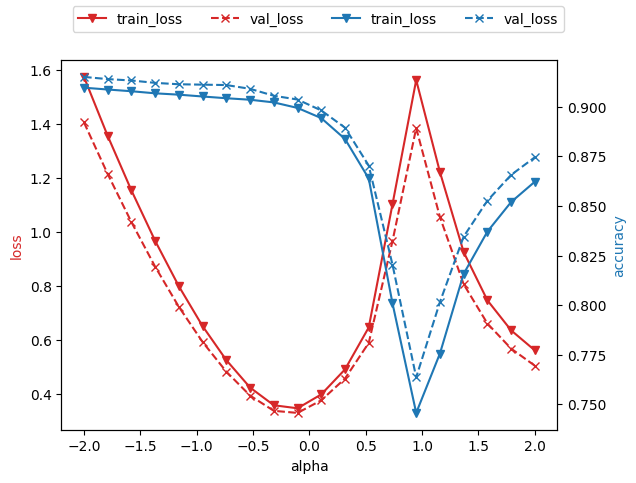

In [21]:
# 'train_loss','val_loss', 'train_acc', 'v_acc','parameters

fig, ax = plt.subplots()
ax.plot(theta_df.alpha, theta_df.train_loss, color = 'tab:red', marker='v', label='train_loss')
ax.plot(theta_df.alpha, theta_df.val_loss, color= 'tab:red', marker='x', linestyle='dashed', label='val_loss')
ax.set_xlabel('alpha')
ax.set_ylabel('loss', color='tab:red')

ax2 = ax.twinx()
ax2.plot(theta_df.alpha, theta_df.t_acc, color='tab:blue', marker = 'v', label='train_loss')
ax2.plot(theta_df.alpha, theta_df.v_acc, color='tab:blue', marker = 'x', linestyle='dashed', label='val_loss')
ax2.set_ylabel('accuracy', color='tab:blue')
fig.legend(loc='upper center', ncols = 4)



